## Нейронные сети. Персептрон

Одна из ранних попыток реализовать что-то, похожее на современные нейронные сети, была предпринята Франком Розенблаттом в 1957 г. Это была аппаратная реализация под названием "Mark-1", предназначенная для распознавания простейших геометрических фигур, таких как треугольники, квадраты и круги.

|      |      |
|--------------|-----------|
|<img src='images/Rosenblatt-wikipedia.jpg' alt='Frank Rosenblatt'/> | <img src='images/Mark_I_perceptron_wikipedia.jpg' alt='The Mark 1 Perceptron' />|

Входное изображение представлялось массивом фотоэлементов размером 20x20, т.е. у нейросети было 400 входов и один выход. В такой сети по сути дела был один решающий нейрон, называемый **пороговым логическим элементом**. Веса сети представляли собой потенциометры, подстраивая которые можно было влиять на поведение сети.

## Модель персептрона

Предположим, у нас есть $N$ входных признаков, т.е. входной вектор $x\in\mathbb{R}^N$. Персептрон - это модель **бинарной классификации**, т.е. она различает между двумя классами. Будем считать, что выход персептрона принимает значения $\{+1, -1\}$, в этом случае выход будет вычисляться по формуле

$$
y(x) = f(w^Tx)
$$
где $f$ - ступенчатая функция активации
$$
f(x) = \begin{cases} +1 & x \geq 0 \\ -1 & x < 0 \end{cases}
$$

## Обучение персептрона

Для обучения нам необходимо найти вектор $w$, который будет наиболее точно распознавать входные примеры, т.е. приводить к минимальной **ошибке**. Ошибка определяется **критерием персептрона**:

$$
E(w) = -\sum_{i\in\Mu} w^Tx_it_i
$$
где

* сумма берется по тем точкам $i\in\Mu$, в которых персептрон ошибается, т.е. $\Mu=\{ i | f(w^Tx_i)\ne y_i\}$
* $x_i$ - входые данные, а $t_i\in\{-1,+1\}$ в зависимости от того, положительные или отрицательные примеры имеются в виду

Этот критерий можно рассматривать как функцию $w$, и необходимо его минимизировать. Для этого используется известный нам метод **градиентного спуска**, в котором мы начинаем с некоторого случайного значения весов $w^{(0)}$, и на каждом шаге подстраиваем веса следующим образом:

$$
w^{(t+1)} = w^{(t)} - \eta\nabla E(w^{(t)})
$$
где
$\eta$ - **коэффициент скорости обучения**, $\nabla E(w)$ обозначает **градиент** E. Вычислив градиент, формулу можно записать в виде

$$
w^{(t+1)} = w^{(t)} + \eta \sum x_it_i
$$

In [5]:
import pylab
from matplotlib import gridspec
from sklearn.datasets import make_classification
import numpy as np
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import pickle
import os
import gzip

# pick the seed for reproducability - change it to explore the effects of random variations
np.random.seed(1)
import random

### Двумерная задача

Начнём с традиционной двумерной задачи классфикации. Сгенерируем датасет с помощью `make_classification`, и разобъем на обучающую и тестовую выборки:

In [6]:
n = 50
X, Y = make_classification(n_samples = n, n_features=2,
                           n_redundant=0, n_informative=2, flip_y=0)
Y = Y*2-1 # convert initial 0/1 values into -1/1
X = X.astype(np.float32); Y = Y.astype(np.int32) # features - float, label - int

# Split the dataset into training and test
train_x, test_x = np.split(X, [ n*8//10])
train_labels, test_labels = np.split(Y, [n*8//10])
print("Features:\n",train_x[0:4])
print("Labels:\n",train_labels[0:4])

Features:
 [[-1.7441838  -1.3952037 ]
 [ 2.5921783  -0.08124504]
 [ 0.9218062   0.91789985]
 [-0.8437018  -0.18738253]]
Labels:
 [-1 -1  1 -1]


Опишем функцию для визуализации датасета:

C:\Users\dmitr\AppData\Local\Temp\ipykernel_6644\2456380072.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


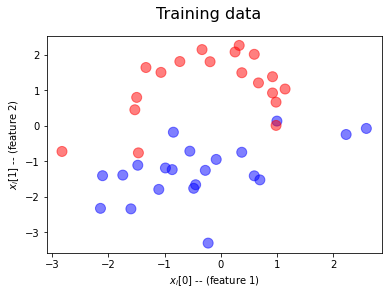

In [7]:
def plot_dataset(suptitle, features, labels):
    # prepare the plot
    fig, ax = pylab.subplots(1, 1)
    #pylab.subplots_adjust(bottom=0.2, wspace=0.4)
    fig.suptitle(suptitle, fontsize = 16)
    ax.set_xlabel('$x_i[0]$ -- (feature 1)')
    ax.set_ylabel('$x_i[1]$ -- (feature 2)')

    colors = ['r' if l>0 else 'b' for l in labels]
    ax.scatter(features[:, 0], features[:, 1], marker='o', c=colors, s=100, alpha = 0.5)
    fig.show()

plot_dataset('Training data', train_x, train_labels)

### Учитываем сдвиг

Как мы знаем, линейная модель имеет вид $y(x)=w^Tx+b$, т.е. параметрами модели являются веса $w$ и сдвиг (bias) $b$. Для упрощения модели персептрона, по традиции расширяют исходный датасет дополнительным признаком, который всегда равен 1. Сформируем множество положительных и отрицательных примеров, расширив их единичным столбцом:

In [8]:
pos_examples = np.array([ [t[0], t[1], 1] for i,t in enumerate(train_x) 
                          if train_labels[i]>0])
neg_examples = np.array([ [t[0], t[1], 1] for i,t in enumerate(train_x) 
                          if train_labels[i]<0])
print(pos_examples[0:3])

[[ 0.92180622  0.91789985  1.        ]
 [-1.06435513  1.49764717  1.        ]
 [ 0.32839951  2.25677919  1.        ]]


### Алгоритм обучения

В процессе обучения мы будет каждый раз выбирать один положительный и отрицательный пример, и если он классифицирован не правильно - применять формулу подстройки коэффициентов:

$$\mathbf{w}^{\tau + 1} = \mathbf{w}^{\tau} + \eta \mathbf{x}_{n} t_{n}$$

In [9]:
def train(positive_examples, negative_examples, num_iterations = 100, eta = 1, report_frequency = 10):
    
    num_dims = positive_examples.shape[1]
    
    # Для простоты инициализируем веса нулями
    weights = np.zeros((num_dims,1)) 
    
    pos_count = positive_examples.shape[0]
    neg_count = negative_examples.shape[0]
    
    for i in range(num_iterations):

        pos = random.choice(positive_examples)
        neg = random.choice(negative_examples)

        z = np.dot(pos, weights)   
        if z < 0: # позитивный пример классифицирован как негативный
            weights = weights + pos.reshape(weights.shape)

        z  = np.dot(neg, weights)
        if z >= 0: # негативный пример классифицирован как позитивный
            weights = weights - neg.reshape(weights.shape)
            
        # Periodically, print out the current accuracy on all examples 
        if i % report_frequency == 0:             
            pos_out = np.dot(positive_examples, weights)
            neg_out = np.dot(negative_examples, weights)        
            pos_correct = (pos_out >= 0).sum() / float(pos_count)
            neg_correct = (neg_out < 0).sum() / float(neg_count)
            print("Iteration={}, pos correct={}, neg correct={}".format(i,pos_correct,neg_correct))

    return weights

Запускаем обучение и смотрим на результат:

In [10]:
wts = train(pos_examples,neg_examples)
print(wts.transpose())

Iteration=0, pos correct=0.10526315789473684, neg correct=0.9047619047619048
Iteration=10, pos correct=0.8421052631578947, neg correct=0.9523809523809523
Iteration=20, pos correct=0.9473684210526315, neg correct=0.9047619047619048
Iteration=30, pos correct=0.8421052631578947, neg correct=1.0
Iteration=40, pos correct=0.8947368421052632, neg correct=0.6666666666666666
Iteration=50, pos correct=0.8947368421052632, neg correct=0.9047619047619048
Iteration=60, pos correct=0.8947368421052632, neg correct=0.9523809523809523
Iteration=70, pos correct=0.8421052631578947, neg correct=1.0
Iteration=80, pos correct=0.8947368421052632, neg correct=0.9523809523809523
Iteration=90, pos correct=0.8421052631578947, neg correct=0.9523809523809523
[[-1.10795674  4.16659402  0.        ]]


Как видно, начальная точность около 50%, но она вскоре близко приближается к 1.

Чтобы визуализировать границу разделения классов, надо построить прямую $\mathbf{w}^Tx = 0$. В нашем случае уравнение прямой будет иметь вид $w_0x_0+w_1x_1+w_2 = 0$ (напомним, что мы добавили дополнительную размерность $x_2=1$). Построим эту прямую:

In [11]:
def plot_boundary(positive_examples, negative_examples, weights):
    if np.isclose(weights[1], 0):
        if np.isclose(weights[0], 0):
            x = y = np.array([-6, 6], dtype = 'float32')
        else:
            y = np.array([-6, 6], dtype='float32')
            x = -(weights[1] * y + weights[2])/weights[0]
    else:
        x = np.array([-6, 6], dtype='float32')
        y = -(weights[0] * x + weights[2])/weights[1]

    pylab.xlim(-6, 6)
    pylab.ylim(-6, 6)                      
    pylab.plot(positive_examples[:,0], positive_examples[:,1], 'bo')
    pylab.plot(negative_examples[:,0], negative_examples[:,1], 'ro')
    pylab.plot(x, y, 'g', linewidth=2.0)
    pylab.show()

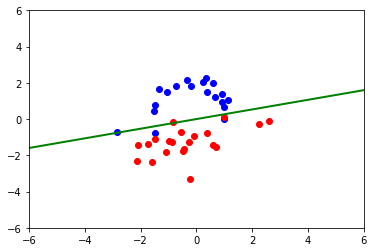

In [12]:
plot_boundary(pos_examples,neg_examples,wts)

### Вычисляем на тестовом датасете

Чтобы посчитать точность на тестовом датасете нам необходимо добавить в него дополнительное "единичное" измерение, умножить на матрицу весов, и затем посчитать количество значений, в которых ожидаемое и предсказанное значения совпадают (или, что тоже самое, их произведение положительно):

In [13]:
def accuracy(weights, test_x, test_labels):
    res = np.dot(np.c_[test_x,np.ones(len(test_x))],weights)
    return (res.reshape(test_labels.shape)*test_labels>=0).sum()/float(len(test_labels))

accuracy(wts, test_x, test_labels)

1.0

### Наблюдаем за обучающим процессом

Для наглядности мы можем в процессе обучения "собирать" промежуточные значения весов и соответствующую им точность, чтобы затем визуализировать, как меняется разделяющая прямая в процессе обучения:

In [14]:
def train_graph(positive_examples, negative_examples, num_iterations = 100):
    num_dims = positive_examples.shape[1]
    weights = np.zeros((num_dims,1)) # initialize weights
    
    pos_count = positive_examples.shape[0]
    neg_count = negative_examples.shape[0]
    
    report_frequency = 15;
    snapshots = []
    
    for i in range(num_iterations):
        pos = random.choice(positive_examples)
        neg = random.choice(negative_examples)

        z = np.dot(pos, weights)   
        if z < 0:
            weights = weights + pos.reshape(weights.shape)

        z  = np.dot(neg, weights)
        if z >= 0:
            weights = weights - neg.reshape(weights.shape)
            
        if i % report_frequency == 0:             
            pos_out = np.dot(positive_examples, weights)
            neg_out = np.dot(negative_examples, weights)        
            pos_correct = (pos_out >= 0).sum() / float(pos_count)
            neg_correct = (neg_out < 0).sum() / float(neg_count)
            snapshots.append((np.copy(weights),(pos_correct+neg_correct)/2.0))

    return np.array(snapshots,dtype=object)

snapshots = train_graph(pos_examples,neg_examples)

def plotit(pos_examples,neg_examples,snapshots,step):
    fig = pylab.figure(figsize=(10,4))
    fig.add_subplot(1, 2, 1)
    plot_boundary(pos_examples, neg_examples, snapshots[step][0])
    fig.add_subplot(1, 2, 2)
    pylab.plot(np.arange(len(snapshots[:,1])), snapshots[:,1])
    pylab.ylabel('Accuracy')
    pylab.xlabel('Iteration')
    pylab.plot(step, snapshots[step,1], "bo")
    pylab.show()
def pl1(step): plotit(pos_examples,neg_examples,snapshots,step)

In [15]:
interact(pl1, step=widgets.IntSlider(value=0, min=0, max=len(snapshots)-1))

interactive(children=(IntSlider(value=0, description='step', max=6), Output()), _dom_classes=('widget-interact…

<function __main__.pl1(step)>

## Ограничения персептрона

Как мы понимаем, персептрон является **линейным классификатором**, и хорошо работает на классах, которые являются **линейно разделимыми**, т.е. могут быть разделены прямой или (в случае большей размерности) гиперплоскостью. В противном случае обучающий процесс не будет сходиться.

Один из известных примеров, когда персептрон не работает - это проблема **исключающего ИЛИ**. Мы пытаемся заставить персептрон аппроксимировать логическую функцию исключающего ИЛИ, которая имеет следующую таблицу истинности:

|   | 0 | 1 |
|---|---|---|
| 0 | 0 | 1 | 
| 1 | 1 | 0 |

Давайте попробуем это сделать. Для этого вручную заполним массивы положительных и отрицательных примеров, и вызовем нашу обучающую функцию:

In [16]:
pos_examples_xor = np.array([[1,0,1],[0,1,1]])
neg_examples_xor = np.array([[1,1,1],[0,0,1]])

snapshots_xor = train_graph(pos_examples_xor,neg_examples_xor,1000)
def pl2(step): plotit(pos_examples_xor,neg_examples_xor,snapshots_xor,step)

In [17]:
interact(pl2, step=widgets.IntSlider(value=0, min=0, max=len(snapshots)-1))

interactive(children=(IntSlider(value=0, description='step', max=6), Output()), _dom_classes=('widget-interact…

<function __main__.pl2(step)>

Как видно из примера, точность никогда не превышает 75%, потому что разделяющая функция всегда будет неправильно классифицировать хотя бы одну точку.

Проблема исключающего ИЛИ является классической задачей, которую не может решить персептрон, и она была рассмотрена Марвином Минским и Сеймуром Папертом в 1969 году в книге [Персептроны](https://en.wikipedia.org/wiki/Perceptrons_(book)). Это привело к временному снижению интереса к нейронным сетям со стороны большинства исследователей, хотя, как мы увидим позднее, многослойные персептроны способны решать линейно неразделяемые задачи. 

## Персептрон и MNIST

Посмотрим, насколько хорошо персептрон справится с уже известным нам датасетом [MNIST](https://en.wikipedia.org/wiki/MNIST_database):

In [18]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784')

features = np.array(mnist.data, dtype=np.float32)/256.0
labels = np.array([int(x) for x in mnist.target])

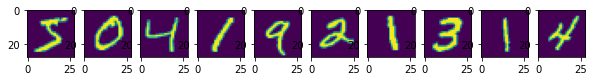

In [19]:
fig = pylab.figure(figsize=(10,5))
for i in range(10):
    ax = fig.add_subplot(1,10,i+1)
    pylab.imshow(features[i].reshape(28,28))
pylab.show()

Поскольку персептрон является бинарным классфикатором, мы ограничимся проблемой распознавания между двумя различными цифрами. Определим функцию, которая загружает в массивы положительных и отрицательных примеров соответствующие изображения цифр:

In [20]:
def set_mnist_pos_neg(positive_label, negative_label):
    positive_indices = [i for i, j in enumerate(labels) if j == positive_label]
    negative_indices = [i for i, j in enumerate(labels) if j == negative_label]

    positive_images = features[positive_indices]
    negative_images = features[negative_indices]

    fig = pylab.figure()
    ax = fig.add_subplot(1, 2, 1)
    pylab.imshow(positive_images[0].reshape(28,28), cmap='gray', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    ax = fig.add_subplot(1, 2, 2)
    pylab.imshow(negative_images[0].reshape(28,28), cmap='gray', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    pylab.show()
    
    return positive_images, negative_images

Для начала попробуем построить классификатор 0-1:

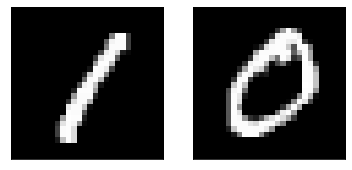

In [21]:
pos1,neg1 = set_mnist_pos_neg(1,0)

In [22]:
def plotit2(snapshots_mn,step):
    fig = pylab.figure(figsize=(10,4))
    ax = fig.add_subplot(1, 2, 1)
    pylab.imshow(snapshots_mn[step][0].reshape(28, 28), interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    pylab.colorbar()
    ax = fig.add_subplot(1, 2, 2)
    ax.set_ylim([0,1])
    pylab.plot(np.arange(len(snapshots_mn[:,1])), snapshots_mn[:,1])
    pylab.plot(step, snapshots_mn[step,1], "bo")
    pylab.show()
def pl3(step): plotit2(snapshots_mn,step)
def pl4(step): plotit2(snapshots_mn2,step)    

In [23]:
snapshots_mn = train_graph(pos1,neg1,1000)    
interact(pl3, step=widgets.IntSlider(value=0, min=0, max=len(snapshots_mn) - 1))

interactive(children=(IntSlider(value=0, description='step', max=66), Output()), _dom_classes=('widget-interac…

<function __main__.pl3(step)>

Точность очень быстро приближается к 100%.

Если подвинуть рычажок ближе к концу и посмотреть на матрицу весов слева, то становится понятно, как работает персептрон. Мы видим большие значения весов в середине поля, в тех местах, где присутствуют пиксели, типичные для цифры 1. В то же время по бокам, где часто встречаются пиксели цифры 0, веса имеют негативные значения. Таким образом, если на вход подаётся 1, то пиксели умножаются преимущественно на положительные коэффициенты, и в результате получается положительное значение; если же на вход подаётся 0, то отрицательное.

> Можно заметить, что если подать на вход цифру 1, слегка сдвинутую вправо или влево по горизонтали, то её пиксели попадут в зону отрицательных значений в матрице весов, и мы получим неверную классификацию. Для более точного распознавания формы цифры вне зависимости от местоположения используются свёрточные сети, о которых мы поговорим далее в курсе.

Теперь попробуем другие цифры: 

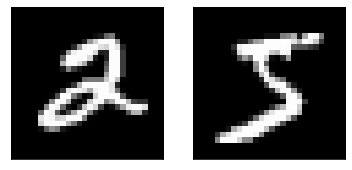

In [24]:
pos2,neg2 = set_mnist_pos_neg(2,5)

In [25]:
snapshots_mn2 = train_graph(pos2,neg2,1000)
interact(pl4, step=widgets.IntSlider(value=0, min=0, max=len(snapshots_mn2) - 1))

interactive(children=(IntSlider(value=0, description='step', max=66), Output()), _dom_classes=('widget-interac…

<function __main__.pl4(step)>

Мы видим, что для цифр 2 и 5 ситуация не такая радужная, точность ниже. Вспомним, как мы применяли метод главных компонент для снижения размерности и визуализации разделимости цифр на плоскости:

In [26]:
from sklearn.decomposition import PCA

def pca_analysis(positive_label, negative_label):
    positive_images, negative_images = set_mnist_pos_neg(positive_label, negative_label)
    M = np.append(positive_images, negative_images, 0)

    mypca = PCA(n_components=2)
    mypca.fit(M)
    
    pos_points = mypca.transform(positive_images[:200])
    neg_points = mypca.transform(negative_images[:200])

    pylab.plot(pos_points[:,0], pos_points[:,1], 'bo')
    pylab.plot(neg_points[:,0], neg_points[:,1], 'ro')

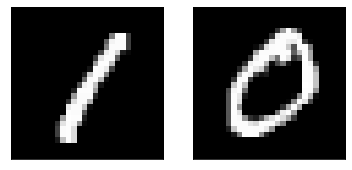

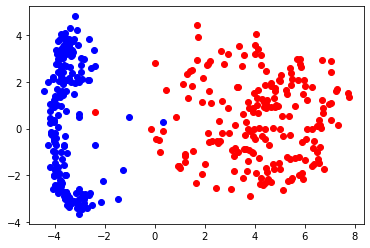

In [27]:
pca_analysis(1,0)

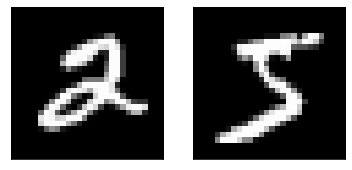

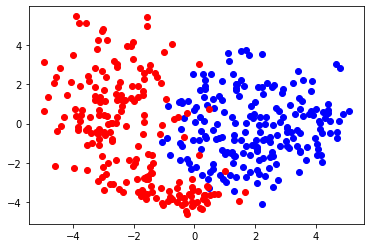

In [28]:
pca_analysis(2,5)

Из графиков видно, что 1 и 0 легко могут быть разделены прямой, в то время как между 2 и 5 сложнее провести разделение.

> Далее в курсе мы увидим, что нейросети позволяют использовать произвольные (не только линейные)разделительные поверхности за счет использования нескольких слоёв. Мы также научимся классифицировать рукописные цифры MNIST с точностью около 99% в задаче мультиклассовой классификации.